### Cargar Librerías

En esta sección, se importan las librerías necesarias para el desarrollo del modelo predictivo de temperatura, que es el enfoque principal de mi tesis. Las librerías seleccionadas abarcan diversas áreas, incluyendo el análisis de datos, la visualización, el deep learning y la gestión de datos climáticos. Utilizando estas herramientas, se podrá realizar un preprocesamiento efectivo de los datos, entrenar modelos de redes neuronales recurrentes y evaluar su rendimiento, lo que permitirá obtener pronósticos precisos para la temperatura en la ciudad de Piura.

#### Especificaciones del Hardware

El desarrollo se llevará a cabo en una computadora portátil de la marca HP con las siguientes características:

- **CPU**: Intel 12th Gen i5-12450H
- **RAM**: 16 GB
- **Disco**: SSD Samsung
- **GPU**: Intel UHD Graphics y NVIDIA GeForce RTX 3050

El modelo se ejecutará utilizando la CPU para garantizar la compatibilidad y eficiencia en el procesamiento de datos.

In [1]:
# =============================================================================
# LIBRERÍAS BÁSICAS DE ANÁLISIS DE DATOS Y VISUALIZACIÓN
# =============================================================================
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

# =============================================================================
# DEEP LEARNING - PYTORCH
# =============================================================================
import torch

# =============================================================================
# PREPROCESAMIENTO Y EVALUACIÓN DE MODELOS
# =============================================================================
from sklearn.preprocessing import StandardScaler

# =============================================================================
# GESTIÓN DE DATOS CLIMÁTICOS Y MODELOS
# =============================================================================
from gestor_datos_climaticos import GestorDatosClimaticos
from modelo_lstm import LSTM
from funciones_auxiliares import (
    asignar_estacion,
    plot_temperature_errors,
    plot_training_history,
    train
)

# =============================================================================
# CONFIGURACIÓN GLOBAL
# =============================================================================
import os
import warnings
import joblib

# Desactivar advertencias para una salida más limpia
warnings.filterwarnings('ignore')

# Configurar pandas para mostrar todas las columnas
pd.set_option('display.max_columns', None)

# Configuración del dispositivo (GPU o CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Configuración de reproducibilidad
RANDOM_SEED = 123
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

cpu


### Inicialización del Gestor de Base de Datos y Obtención de Datos Climáticos

En esta sección, se inicializa el gestor de base de datos, que se encargará de manejar la información climática para la ciudad de Piura. Se establece la variable `ciudad` con el nombre de la ciudad de interés (Piura) y se crea una instancia de la clase `GestorDatosClimaticos`.

A continuación, se utiliza el método `obtener_id_ciudad_por_nombre` del gestor de base de datos para obtener el identificador único asociado a la ciudad de Piura. Este identificador es fundamental para realizar consultas específicas en la base de datos.

Posteriormente, se llama al método `obtener_dataframe` para obtener un DataFrame que contenga los datos climáticos de la ciudad, utilizando el identificador de la ciudad previamente obtenido. Este DataFrame será el punto de partida para el análisis y modelado de los datos en el desarrollo del modelo predictivo.


In [2]:
# Inicializar el gestor de base de datos
ciudad = 'Piura'
gestor_db = GestorDatosClimaticos()
id_ciudad = gestor_db.obtener_id_ciudad_por_nombre(ciudad)

# Obtener y procesar datos
df_clima = gestor_db.obtener_dataframe('clima', id_ciudad)

A continuación, se utiliza el método `head()` del DataFrame `df_clima` para mostrar las primeras (5) filas del conjunto de datos climáticos obtenido. Esta función es útil para tener una vista rápida de la estructura y el contenido del DataFrame, permitiendo verificar que los datos se han cargado correctamente. Al observar las primeras filas, podemos identificar las columnas disponibles y asegurarnos de que la información sea coherente con lo que se espera para el análisis posterior.

In [3]:
df_clima.head()

,id_ciudad,time,tmax,tmin,tavg,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,1,2018-07-20,27.4,17.2,21.7,0.0,0.0,172,15.1,0.0,1012.3,0.0
1,1,2018-07-21,27.8,17.9,21.9,0.0,0.0,174,13.6,0.0,1012.5,0.0
2,1,2018-07-22,29.0,17.8,21.6,0.0,0.0,175,12.4,0.0,1013.1,0.0
3,1,2018-07-23,27.8,18.1,21.3,0.0,0.0,177,13.5,0.0,1013.9,0.0
4,1,2018-07-24,28.6,17.9,20.4,0.0,0.0,175,12.1,0.0,1015.0,0.0


Se utiliza el método `info()` del DataFrame `df_clima` para obtener un resumen de la estructura del conjunto de datos. Este método proporciona información sobre el número de entradas, el tipo de datos de cada columna y la cantidad de valores no nulos. Es una herramienta útil para evaluar la calidad de los datos y detectar posibles problemas, como valores faltantes o tipos de datos incorrectos.

In [4]:
df_clima.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id_ciudad  2356 non-null   int64         
 1   time       2356 non-null   datetime64[ns]
 2   tmax       2356 non-null   float64       
 3   tmin       2356 non-null   float64       
 4   tavg       2356 non-null   float64       
 5   prcp       2356 non-null   float64       
 6   snow       2356 non-null   float64       
 7   wdir       2356 non-null   int64         
 8   wspd       2356 non-null   float64       
 9   wpgt       2356 non-null   float64       
 10  pres       2356 non-null   float64       
 11  tsun       2356 non-null   float64       
dtypes: datetime64[ns](1), float64(9), int64(2)
memory usage: 221.0 KB


Después de verificar que el DataFrame `df_clima` está completo y que todos los datos se han cargado correctamente, sin valores nulos ni inconsistencias, se procede a realizar el preprocesamiento necesario para el análisis. Esto incluye convertir la columna `time` a tipo datetime, extraer el mes y el día, y aplicar la función `asignar_estacion` para clasificar los datos según la estación del año.

Se crean columnas indicadoras para las estaciones y los meses utilizando codificación one-hot. La información obtenida del método `info()` confirma que el DataFrame contiene 2,353 entradas y 12 columnas, todas con datos no nulos. Las columnas incluyen variables climáticas como `tmax`, `tmin`, `tavg`, entre otras, lo que asegura que se cuenta con la información necesaria para el desarrollo del modelo predictivo.

In [5]:
# Asegúrate de que la columna 'time' sea de tipo datetime
df_clima['time'] = pd.to_datetime(df_clima['time'])

# Extraer el mes y el día
df_clima['mes'] = df_clima['time'].dt.month
df_clima['dia'] = df_clima['time'].dt.day

# Aplicar la función para crear la columna 'estacion'
df_clima['estacion'] = df_clima.apply(asignar_estacion, axis=1)

# Crear columnas indicadoras de las estaciones con valores 0 y 1
estaciones_dummies = pd.get_dummies(df_clima['estacion'], prefix='', drop_first=False).astype(int)

# Renombrar las columnas de las estaciones para que sean simplemente el nombre de la estación
estaciones_dummies.columns = estaciones_dummies.columns.str.strip()

# Renombrar las columnas para eliminar el guion bajo
estaciones_dummies.columns = estaciones_dummies.columns.str.replace('_', '', regex=False)

# Agregar las columnas de las estaciones al DataFrame original
df = pd.concat([df_clima, estaciones_dummies], axis=1)

# Crear columnas indicadoras para los meses
meses_dummies = pd.get_dummies(df_clima['mes'], prefix='mes').astype(int)

# Agregar las columnas de meses al DataFrame original
df = pd.concat([df, meses_dummies], axis=1)

### Analisis de los datos

En esta sección, se realizará un análisis exploratorio de los datos climáticos de Piura. Se examinarán las tendencias y patrones en las variables de temperatura, precipitación y otras métricas relevantes. Además, se visualizarán los datos para identificar correlaciones y anomalías, lo que permitirá comprender mejor el comportamiento climático y su relación con las estaciones del año.

In [6]:
# Mostrar las primeras 5 filas del DataFrame
print(df.head())

   id_ciudad       time  tmax  tmin  tavg  prcp  snow  wdir  wspd  wpgt  \
0          1 2018-07-20  27.4  17.2  21.7   0.0   0.0   172  15.1   0.0   
1          1 2018-07-21  27.8  17.9  21.9   0.0   0.0   174  13.6   0.0   
2          1 2018-07-22  29.0  17.8  21.6   0.0   0.0   175  12.4   0.0   
3          1 2018-07-23  27.8  18.1  21.3   0.0   0.0   177  13.5   0.0   
4          1 2018-07-24  28.6  17.9  20.4   0.0   0.0   175  12.1   0.0   

     pres  tsun  mes  dia  estacion  Invierno  Otoño  Primavera  Verano  \
0  1012.3   0.0    7   20  Invierno         1      0          0       0   
1  1012.5   0.0    7   21  Invierno         1      0          0       0   
2  1013.1   0.0    7   22  Invierno         1      0          0       0   
3  1013.9   0.0    7   23  Invierno         1      0          0       0   
4  1015.0   0.0    7   24  Invierno         1      0          0       0   

   mes_1  mes_2  mes_3  mes_4  mes_5  mes_6  mes_7  mes_8  mes_9  mes_10  \
0      0      0      0

Se puede observar que los datos están bien cargados y estructurados. Las columnas incluyen información sobre las variables climáticas, como `tmax`, `tmin` y `tavg`, así como datos de precipitación y nieve. Además, las estaciones se han codificado en formato binario, facilitando el análisis posterior.

In [7]:
# Obtener estadísticas descriptivas de las primeras 10 filas
print(df.describe())

       id_ciudad                 time         tmax         tmin         tavg  \
count     2356.0                 2356  2356.000000  2356.000000  2356.000000   
mean         1.0  2021-10-09 12:00:00    30.506452    19.575891    24.035314   
min          1.0  2018-07-20 00:00:00    24.400000     2.000000    17.900000   
25%          1.0  2020-02-28 18:00:00    28.400000    17.200000    21.600000   
50%          1.0  2021-10-09 12:00:00    30.200000    19.300000    23.750000   
75%          1.0  2023-05-21 06:00:00    32.600000    22.000000    26.400000   
max          1.0  2024-12-30 00:00:00    37.800000    26.000000    31.800000   
std          0.0                  NaN     2.477784     2.788626     2.848927   

              prcp    snow         wdir         wspd    wpgt         pres  \
count  2356.000000  2356.0  2356.000000  2356.000000  2356.0  2356.000000   
mean      0.471180     0.0   183.385823    13.856664     0.0  1012.653098   
min       0.000000     0.0    15.000000     5.50

Los datos muestran un recuento de 2353 observaciones, con estadísticas descriptivas que indican que la temperatura máxima promedio (`tmax`) es de 30.51 °C y la mínima (`tmin`) de 19.57 °C. La precipitación promedio es de 0.47 mm, lo que sugiere un clima mayormente seco, mientras que las columnas de estaciones y meses presentan una distribución binaria que facilita el análisis estacional.

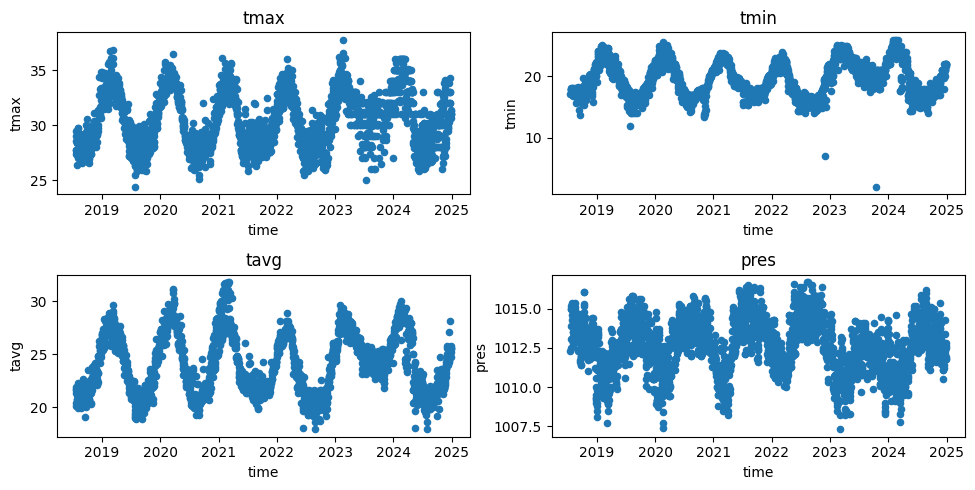

In [8]:
# Definimos la lista de columnas que queremos graficar
columnas_a_graficar = ['tmax', 'tmin', 'tavg', 'pres']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
axes = axes.flat

# Graficar cada columna en la lista
for ncol, colname in enumerate(columnas_a_graficar):
    if colname in df.columns: 
        df.plot(x='time', y=colname, kind='scatter', ax=axes[ncol])
        axes[ncol].set_title(colname) 
    else:
        print(f"Columna '{colname}' no encontrada en el DataFrame.")

plt.tight_layout() 
plt.show()


Al analizar las variables más importantes y con mayor dispersión de datos, se observa que en la variable `tmin` hay dos datos atípicos. Estos valores pueden ser el resultado de errores de medición o condiciones climáticas extremas que no se registraron adecuadamente. Para corroborar esta anomalía, se utilizará un gráfico de cajas que permitirá identificar visualmente estos datos atípicos.

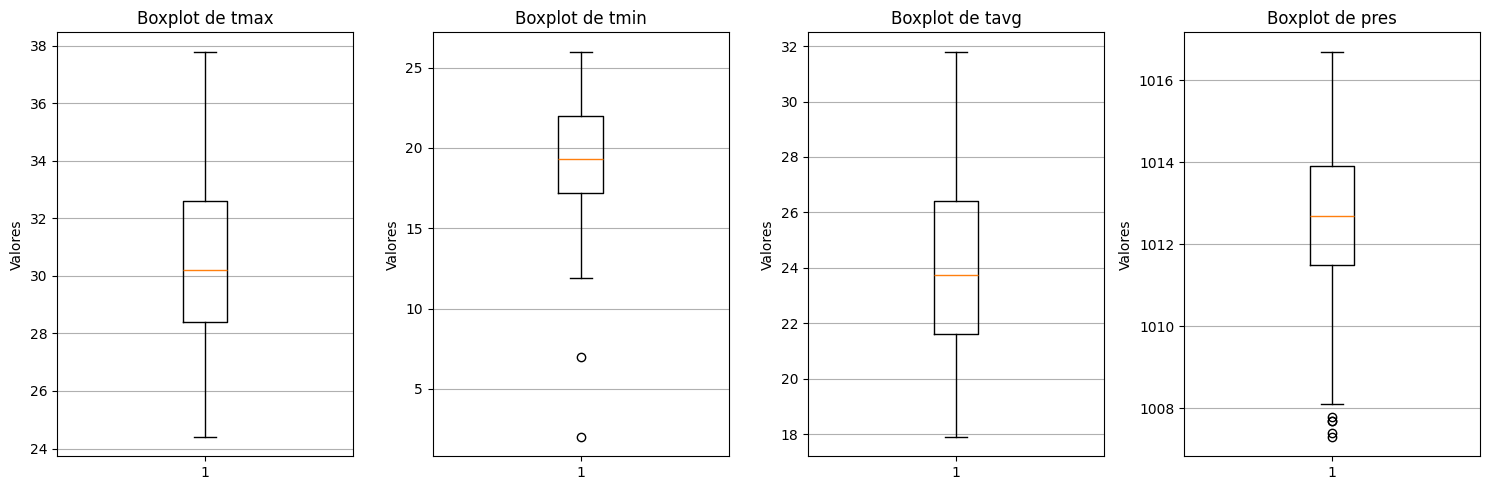

In [9]:
# Crear subplots
fig, axs = plt.subplots(1, len(columnas_a_graficar), figsize=(15, 5))  

# Crear boxplots horizontales
for ax, columna in zip(axs, columnas_a_graficar):
    ax.boxplot(df[columna])
    ax.set_title(f'Boxplot de {columna}')
    ax.set_ylabel('Valores')
    ax.grid(axis='y') 

plt.tight_layout() 
plt.show()

Al visualizar y corroborar lo antes mencionado, en el diagrama de cajas se pueden observar los datos atípicos en la variable `tmin`. Estos valores anómalos refuerzan la hipótesis de que podrían ser el resultado de errores de medición o de condiciones climáticas extremas que no se registraron adecuadamente. Dada esta confirmación, se procederá a calcular la temperatura mínima promedio y, si es necesario, reemplazar los valores de `tmin` que sean inferiores a 10 con este promedio para garantizar la integridad del análisis.

In [10]:
mean_temp_min = df['tmin'].mean()
df['tmin'] = df['tmin'].apply(lambda x: mean_temp_min if x < 10 else x)

Después de realizar la corrección de datos, se procederá a visualizar la desviación de las variables que se cargaron inicialmente, excluyendo las variables de estación y las columnas binarias. Para ello, se calculará la media absoluta de la desviación utilizando la mediana de cada variable. El cálculo se realizará de la siguiente manera:

In [11]:
# Media absoluta de la desviación usando la mediana
df.iloc[:,2:12].apply(lambda x: np.mean(np.abs(x-np.median(x))),axis=0)

tmax    2.120034
tmin    2.365175
tavg    2.461800
prcp    0.471180
snow    0.000000
wdir    7.324703
wspd    1.674491
wpgt    0.000000
pres    1.367954
tsun    0.000000
dtype: float64

Se observa que las variables **nieve** (`snow`), **ráfaga de viento** (`wpgt`) y **horas de sol** (`tsun`) presentan desviaciones medias de cero, indicando que no se registraron eventos durante el periodo analizado. Por lo tanto, se procederá a eliminar estos datos para mejorar la calidad del análisis.

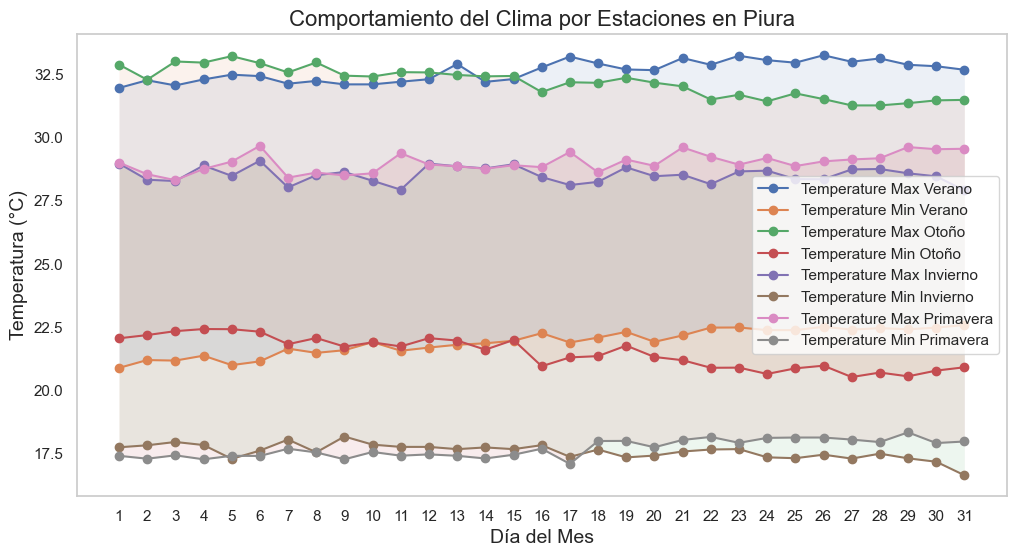

In [12]:
# Calcular promedios por estación y día
promedio_estacion = df_clima.groupby(['dia', 'estacion']).agg({'tmax': 'mean', 'tmin': 'mean', 'tavg': 'mean'}).reset_index()

# Crear un DataFrame para todos los días y todas las estaciones
dias = np.arange(1, 32) 
estaciones = ['Verano', 'Otoño', 'Invierno', 'Primavera']
all_days = pd.MultiIndex.from_product([dias, estaciones], names=['dia', 'estacion'])
promedio_estacion = promedio_estacion.set_index(['dia', 'estacion']).reindex(all_days).reset_index()

# Rellenar los NaN con el método de interpolación o hacia adelante
promedio_estacion.fillna(method='ffill', inplace=True)

# Graficar
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

# Graficar temperatura máxima, mínima y promedio
for estacion in estaciones:
    data = promedio_estacion[promedio_estacion['estacion'] == estacion]
    plt.plot(data['dia'], data['tmax'], label=f'Temperature Max {estacion}', marker='o')
    plt.plot(data['dia'], data['tmin'], label=f'Temperature Min {estacion}', marker='o')
    plt.fill_between(data['dia'], data['tmax'], data['tmin'], alpha=0.1)

# Configurar título y etiquetas
plt.title('Comportamiento del Clima por Estaciones en Piura', fontsize=16)
plt.xlabel('Día del Mes', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(range(1, 32))  # Suponiendo que el mes tiene 31 días
plt.legend()
plt.grid()
plt.show()

El análisis muestra que las temperaturas máximas y mínimas en **otoño** y **verano** son similares a lo largo de los días del mes, con un notable aumento de calor hacia el final de mes en verano, que resulta más cálido que en otoño, pero menos frío. Por otro lado, **primavera** e **invierno** presentan una tendencia similar, con patrones de temperatura que reflejan las diferencias estacionales.

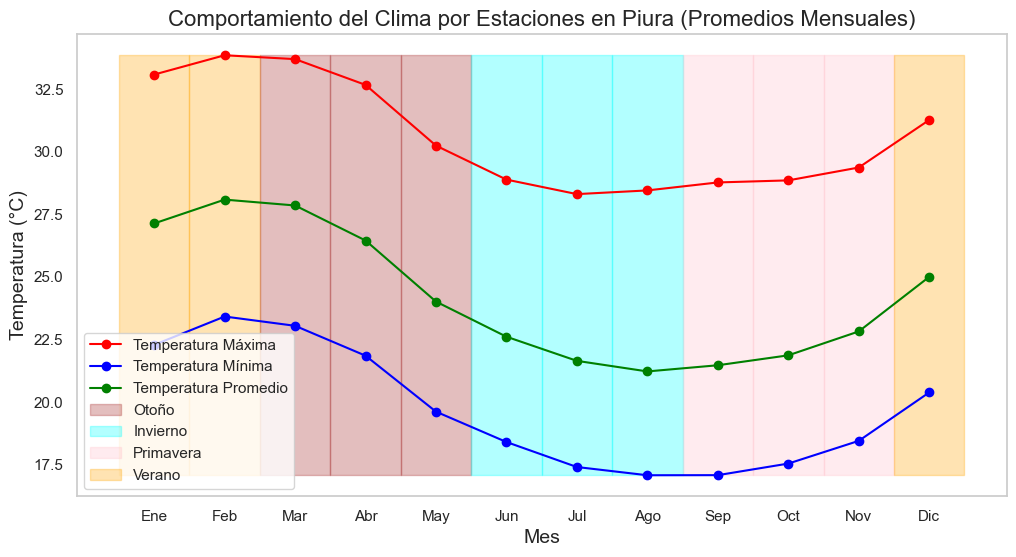

In [13]:
promedio_estacional = df_clima.groupby(['mes']).agg({'tmax': 'mean', 'tmin': 'mean', 'tavg': 'mean'}).reset_index()

# Configurar el estilo de la gráfica
sns.set(style="whitegrid")

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Graficar tmax, tmin, y tavg
plt.plot(promedio_estacional['mes'], promedio_estacional['tmax'], label='Temperatura Máxima', color='red', marker='o')
plt.plot(promedio_estacional['mes'], promedio_estacional['tmin'], label='Temperatura Mínima', color='blue', marker='o')
plt.plot(promedio_estacional['mes'], promedio_estacional['tavg'], label='Temperatura Promedio', color='green', marker='o')

# Rellenar áreas entre líneas de temperatura por estación
for mes in range(1, 13):
    # Establecer los límites de los meses para el relleno
    if mes in [12, 1, 2]:  # Verano
        plt.fill_between([mes - 0.5, mes + 0.5], 
                         promedio_estacional['tmax'].max(), 
                         promedio_estacional['tmin'].min(), 
                         color='orange', alpha=0.3, label='Verano' if mes == 12 else "")
    elif mes in [3, 4, 5]:  # Otoño
        plt.fill_between([mes - 0.5, mes + 0.5], 
                         promedio_estacional['tmax'].max(), 
                         promedio_estacional['tmin'].min(), 
                         color='brown', alpha=0.3, label='Otoño' if mes == 3 else "")
    elif mes in [6, 7, 8]:  # Invierno
        plt.fill_between([mes - 0.5, mes + 0.5], 
                         promedio_estacional['tmax'].max(), 
                         promedio_estacional['tmin'].min(), 
                         color='cyan', alpha=0.3, label='Invierno' if mes == 6 else "")
    elif mes in [9, 10, 11]:  # Primavera
        plt.fill_between([mes - 0.5, mes + 0.5], 
                         promedio_estacional['tmax'].max(), 
                         promedio_estacional['tmin'].min(), 
                         color='pink', alpha=0.3, label='Primavera' if mes == 9 else "")

# Configurar título y etiquetas
plt.title('Comportamiento del Clima por Estaciones en Piura (Promedios Mensuales)', fontsize=16)
plt.xlabel('Mes', fontsize=14)
plt.ylabel('Temperatura (°C)', fontsize=14)
plt.xticks(ticks=range(1, 13), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'])
plt.legend()
plt.grid()

# Mostrar la gráfica
plt.show()

Se observa que al inicio del año, las temperaturas aumentan hasta alcanzar su pico en **febrero**, manteniéndose altas en **marzo**, pero disminuyendo en **abril**, marcando el inicio del otoño. Esta disminución persiste hasta **julio**, que representa el pico más bajo (en promedio, porque la temperatura minima se visualiza a fines de agosto). Posteriormente, las temperaturas comienzan a aumentar, aunque de manera leve durante **primavera**, donde el comportamiento es casi constante. Esto sugiere que **primavera** podría aportar poca información al modelo, ya que las temperaturas máximas se asemejan a las de **invierno**. Sin embargo, se puede notar un ligero aumento en las temperaturas mínimas y promedio durante esta estación.

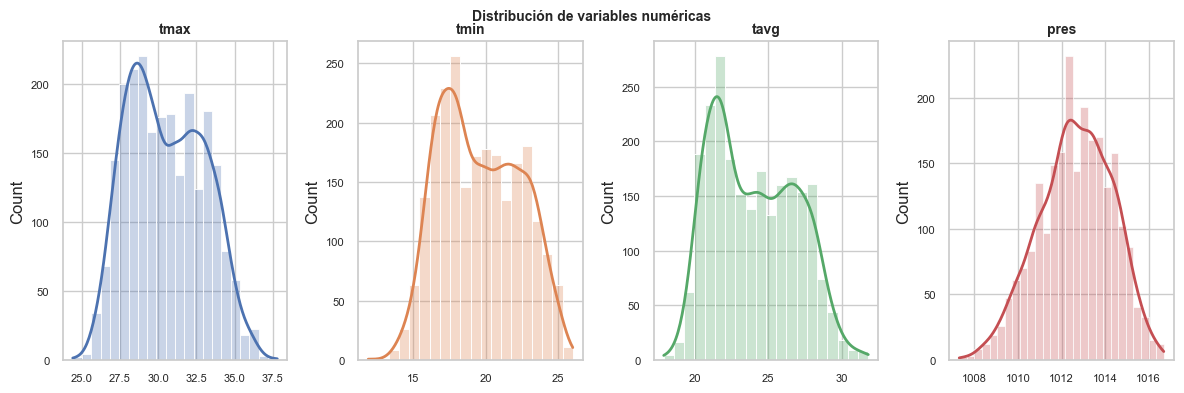

In [14]:
selected_columns = ['tmax', 'tmin', 'tavg', 'pres']

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
axes = axes.flat

for i, column in enumerate(selected_columns):
    sns.histplot(
        data=df,
        x=column,
        stat="count",
        kde=True,
        color=(list(plt.rcParams['axes.prop_cycle'])*2)[i % 10]["color"],
        line_kws={'linewidth': 2},
        alpha=0.3,
        ax=axes[i]
    )
    axes[i].set_title(column, fontsize=10, fontweight="bold")
    axes[i].tick_params(labelsize=8)
    axes[i].set_xlabel("")

fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de variables numéricas', fontsize=10, fontweight="bold")
plt.show()

Las variables presentan distribuciones distintas: `tmax` (azul) muestra una distribución normal con un rango de 25°C a 37.5°C y un ligero bimodalismo, lo que sugiere la posible influencia de dos fenómenos climáticos diferentes que afectan las temperaturas máximas. `tmin` (naranja) tiene un rango de 15°C a 25°C y es asimétrica hacia la derecha, indicando que la mayoría de los valores se agrupan en la parte inferior del rango. `tavg` (verde) es bimodal entre 20°C y 30°C, lo que puede indicar diferentes patrones climáticos a lo largo del tiempo o la presencia de dos grupos distintos de temperaturas promedio. Por último, `pres` (rojo) presenta una distribución simétrica en el rango de 1008 a 1016 hPa, con un pico en torno a 1013-1014 hPa, sugiriendo una presión atmosférica relativamente estable.


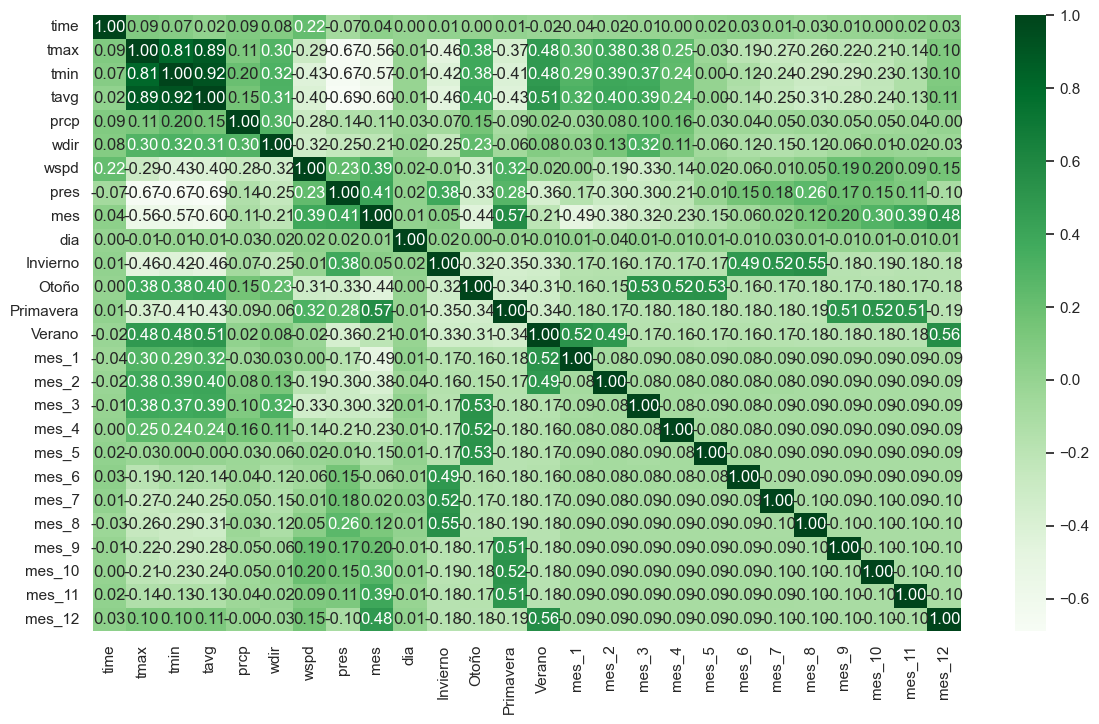

In [15]:
# Eliminar las columnas donde todos sus valores son 0 y la columna 'id_ciudad'
df_cleaned = df.loc[:, (df != 0).any(axis=0)]  # Eliminar columnas con todos ceros

# Excluir 'id_ciudad' si está presente en las columnas
if 'id_ciudad' in df_cleaned.columns:
    df_cleaned = df_cleaned.drop(columns=['id_ciudad','estacion'])

# Calcular la matriz de correlación de las columnas restantes
corr = df_cleaned.corr().round(2)

# Crear un mapa de calor para visualizar la matriz de correlación
plt.figure(figsize=(14, 8))
sns.heatmap(corr, cmap="Greens", annot=True, fmt=".2f")  # fmt controla el formato de anotación
plt.show()

Las correlaciones observadas en las variables climáticas son las siguientes:

- **Correlaciones entre temperaturas**:
  - `tmax` y `tmin` presentan una correlación muy fuerte de **0.89**, mientras que `tavg` está muy fuertemente correlacionada con ambas: **0.92** con `tmin` y **0.81** con `tmax`, lo cual es esperado dado que `tavg` es el promedio.

- **Relaciones con precipitación (prcp)**:
  - Se observa una correlación moderada positiva entre `prcp` y `tmin` (**0.32**), y una correlación más débil con `tmax` (**0.29**). `tavg` muestra una correlación moderada de **0.31**, sugiriendo que temperaturas más altas están asociadas con mayores niveles de precipitación.

- **Relaciones con viento (wdir y wspd)**:
  - La dirección del viento (`wdir`) muestra correlaciones débiles con las temperaturas. En contraste, la velocidad del viento (`wspd`) presenta correlaciones moderadas positivas: **0.43** con `tmin`, **0.29** con `tmax` y **0.40** con `tavg`.

- **Relaciones estacionales**:
  - En verano, las correlaciones son fuertes y positivas con todas las temperaturas, mientras que en invierno se observan correlaciones negativas moderadas. Primavera y otoño muestran correlaciones más débiles.

- **Relaciones mensuales**:
  - Los meses de verano (junio, julio y agosto) evidencian correlaciones positivas más fuertes con las temperaturas, en contraste con los meses de invierno (diciembre, enero y febrero) que tienen correlaciones negativas o más débiles. Se nota un patrón cíclico claro en las correlaciones mensuales.

### Entrenamiento del modelo

#### Entrenar modelo

Se han eliminado las siguientes variables del modelo: `['id_ciudad', 'time', 'snow', 'wpgt', 'tsun', 'estacion', 'Primavera', 'mes_7', 'mes_8', 'mes_9', 'mes_10', 'mes_11', 'mes_12']`. Esta decisión se fundamenta en los siguientes puntos:

1. **Correlación Baja o Nula**: Las variables `Primavera`, `mes_7`, `mes_8`, `mes_9`, `mes_10`, `mes_11` y `mes_12` presentaron correlaciones muy débiles o nulas con las temperaturas. Esto indica que no aportan información relevante para la predicción, lo que justifica su eliminación en el modelo afinado.

2. **Medias Iguales a Cero**: Las variables `snow`, `wpgt` y `tsun` mostraron medias cercanas a cero, sugiriendo que no registraron variaciones significativas durante el período analizado. Su inclusión no contribuye a la explicación de la variabilidad en las temperaturas.

3. **Modelo Afinado**: En el proceso de optimización del modelo, se observó que la importancia de las variables mencionadas es nula o insignificante, lo que indica que su inclusión no mejora la capacidad predictiva y podría complicar el análisis, como es el caso de `Primavera`.

4. **Excepción de `mes_5`**: La variable `mes_5` se mantiene en el modelo, a pesar de tener dos correlaciones a cero. Esto se debe a que, en el contexto del modelo afinado, se ha demostrado que `mes_5` tiene una importancia significativa al predecir las variables, sugiriendo que puede estar relacionada con otros factores que no se reflejan solo en la correlación.

En conclusión, la eliminación de estas variables contribuye a un modelo más eficiente y interpretable, mientras que la retención de `mes_5` se justifica por su relevancia en las predicciones.

In [16]:
# Definir las características de entrada y las variables de salida
features = [col for col in df.columns if col not in ['id_ciudad', 'time', 'snow', 'wpgt', 'tsun','estacion'
                                                     ,'Primavera','mes_7','mes_8','mes_9','mes_10','mes_11','mes_12']] 
target_features = ['tmax', 'tmin', 'tavg']

# Dividir los datos en entrenamiento y validación
df_train = df[df['time'] <= '2023-12-31']
df_val = df[(df['time'] > '2023-12-31') & (df['time'] <= '2024-06-30')]
print(f'La data de entrenamiento tiene {len(df_train)} filas')
print(f'La data de validación tiene {len(df_val)} filas')

La data de entrenamiento tiene 1991 filas
La data de validación tiene 182 filas


Se utilizarán todos los datos hasta el 31 de diciembre de 2023 como conjunto de entrenamiento, mientras que el conjunto de validación abarcará desde el 1 de enero de 2024 hasta el 30 de junio de 2024. El conjunto de entrenamiento consta de 1991 filas, mientras que el conjunto de validación incluye 182 filas.

In [18]:
# Convertir las características de entrada y las salidas a formato numpy
input_data_train = df_train[features].values
input_data_val = df_val[features].values
targets_train = df_train[target_features].values
targets_val = df_val[target_features].values

In [19]:
# Definir la ventana de tiempo (T)
T = 25                                # Número de pasos de tiempo
D = input_data_train.shape[1]         # Dimensión de las características de entrada
N_train = len(input_data_train) - T
N_val = len(input_data_val) - T
output_dim = len(target_features)     # Dimensión de salida

# Normalización de las entradas
scaler = StandardScaler()
scaler.fit(input_data_train[:len(input_data_train) + T - 1])  # Asegúrate de que esta línea esté bien
input_data_train = scaler.transform(input_data_train)
input_data_val = scaler.transform(input_data_val)

In [20]:
# Obtener la ruta del directorio actual
current_directory = os.getcwd()

# Guardar el scaler en un archivo
scaler_path = os.path.join(current_directory, 'escalado.pkl')
joblib.dump(scaler, scaler_path)

print("Scaler guardado exitosamente en", scaler_path)

Scaler guardado exitosamente en c:\Users\Ronaldo Olivares\Desktop\DOCUMENTO DE TESIS\Codigos\escalado.pkl


La ventana de tiempo (T) se ha establecido en 25 pasos de tiempo. Esta elección se fundamenta en la necesidad de capturar patrones relevantes en los datos a lo largo de un período suficientemente extenso, permitiendo que el modelo aprenda relaciones temporales y tendencias en las variables de entrada. Además, se ha calculado el número de instancias de entrenamiento (`N_train`) y de validación (`N_val`) restando T del tamaño total de los conjuntos de datos, lo que garantiza que las series temporales estén alineadas correctamente para el entrenamiento y la validación.

La normalización es un paso crucial en el preprocesamiento de datos, ya que permite que las características de entrada estén en una escala similar, lo que a su vez ayuda a mejorar la convergencia del modelo durante el entrenamiento. Se utiliza el `StandardScaler` para ajustar y transformar los datos de entrada. El scaler se ajusta únicamente a los datos de entrenamiento para evitar la filtración de información del conjunto de validación, asegurando que la evaluación del modelo se mantenga objetiva. Al aplicar la transformación, se garantiza que tanto el conjunto de entrenamiento como el de validación tengan una media de 0 y una desviación estándar de 1, lo que favorece el rendimiento del modelo en la predicción de las variables objetivo.

In [149]:
# Preparar X_train y y_train
X_train = np.zeros((N_train, T, D))
y_train = np.zeros((N_train, output_dim))

for t in range(N_train):
    X_train[t, :, :] = input_data_train[t:t+T]
    y_train[t] = targets_train[t+T]  # Asegúrate de que esta línea esté bien

# Preparar X_test y y_test
X_test = np.zeros((N_val, T, D))
y_test = np.zeros((N_val, output_dim))

for i in range(N_val):
    t = i
    X_test[i, :, :] = input_data_val[t:t+T]
    y_test[i] = targets_val[t+T]  # Asegúrate de que esta línea esté bien

# Convertir las matrices a tensores de PyTorch
X_train = torch.from_numpy(X_train.astype(np.float32)).to(device)
y_train = torch.from_numpy(y_train.astype(np.float32)).to(device)
X_test = torch.from_numpy(X_test.astype(np.float32)).to(device)
y_test = torch.from_numpy(y_test.astype(np.float32)).to(device)

# Verificación de las dimensiones
print(f'X_train shape: {X_train.shape}, y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}, y_test shape: {y_test.shape}')

X_train shape: torch.Size([1966, 25, 18]), y_train shape: torch.Size([1966, 3])
X_test shape: torch.Size([157, 25, 18]), y_test shape: torch.Size([157, 3])


Se construirá un modelo LSTM con 512 neuronas en una sola capa y 3 variables de salida: tmax, tmin y tavg.

In [150]:
model = LSTM(D, 512, 1, 3)
model.to(device)

LSTM(
  (rnn): LSTM(18, 512, batch_first=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

Se entrenará el modelo utilizando una tasa de aprendizaje de 0.01, con un total de 1355 épocas.

In [151]:
# Entrenar el modelo
history = train(model,
                0.01,
                X_train,
                y_train,
                X_test,
                y_test,
                epochs=1355)

At epoch 50/1355, Train Loss: 1.500, Val Loss: 3.874, MAE: 0.945, Val MAE: 1.577, RMSE: 1.225, Val RMSE: 1.968, R^2: 0.778, Val R^2: 0.594
At epoch 100/1355, Train Loss: 1.041, Val Loss: 3.258, MAE: 0.773, Val MAE: 1.346, RMSE: 1.020, Val RMSE: 1.805, R^2: 0.845, Val R^2: 0.660
At epoch 150/1355, Train Loss: 1.000, Val Loss: 3.179, MAE: 0.757, Val MAE: 1.324, RMSE: 1.000, Val RMSE: 1.783, R^2: 0.851, Val R^2: 0.668
At epoch 200/1355, Train Loss: 0.971, Val Loss: 3.129, MAE: 0.744, Val MAE: 1.310, RMSE: 0.986, Val RMSE: 1.769, R^2: 0.855, Val R^2: 0.673
At epoch 250/1355, Train Loss: 0.943, Val Loss: 3.078, MAE: 0.731, Val MAE: 1.298, RMSE: 0.971, Val RMSE: 1.754, R^2: 0.859, Val R^2: 0.679
At epoch 300/1355, Train Loss: 0.908, Val Loss: 3.012, MAE: 0.717, Val MAE: 1.288, RMSE: 0.953, Val RMSE: 1.736, R^2: 0.864, Val R^2: 0.685
At epoch 350/1355, Train Loss: 0.883, Val Loss: 2.961, MAE: 0.706, Val MAE: 1.277, RMSE: 0.940, Val RMSE: 1.721, R^2: 0.868, Val R^2: 0.691
At epoch 400/1355, Tr

In [152]:
historial = pd.DataFrame(history)
historial.head()

,loss,val_loss,mae,val_mae,rmse,val_rmse,r2,val_r2
0,638.983948,702.746521,24.734659,25.959509,25.278137,26.509369,-95.121934,-75.534419
1,627.396240,677.992554,24.508524,25.495718,25.047884,26.038294,-93.377574,-72.835460
2,604.964111,637.657959,24.064735,24.722330,24.596018,25.251888,-90.001124,-68.438609
3,568.825256,563.483459,23.332685,23.235907,23.850067,23.737808,-84.562885,-60.354438
4,503.458618,379.570221,21.948877,19.037237,22.437889,19.482561,-74.730074,-40.309502


Se puede observar que el historial de evolución del modelo se ha guardado correctamente para un análisis posterior.

In [153]:
# Obtener los ultimos valores del historial
max_loss = history['loss'][-1]
max_val_loss = history['val_loss'][-1]
max_mae = history['mae'][-1]
max_val_mae = history['val_mae'][-1]
max_rmse = history['rmse'][-1]
max_val_rmse = history['val_rmse'][-1]

# Imprimir los resultados
print(f'Loss: {max_loss:.6f}')
print(f'Val Loss: {max_val_loss:.6f}')
print(f'MAE: {max_mae:.4f}')
print(f'Val MAE: {max_val_mae:.6f}')
print(f'RMSE: {max_rmse:.6f}')
print(f'Val RMSE: {max_val_rmse:.6f}')

Loss: 0.772744
Val Loss: 2.495031
MAE: 0.6505
Val MAE: 1.178541
RMSE: 0.879059
Val RMSE: 1.579567


El modelo entrenado presenta un error aceptable con un Loss de 0.7727 y un Val Loss de 2.4950, indicando buen ajuste en entrenamiento pero mayor error en validación.

In [154]:
history_df = pd.DataFrame(history)
min_index = history_df['val_loss'].idxmin()
min_val_loss_row = history_df.iloc[min_index]
print(f"Índice de la fila con el valor mínimo de 'val_loss': {min_index}")
print(f"Datos de la fila con el valor mínimo de 'val_loss':\n{min_val_loss_row}")

Índice de la fila con el valor mínimo de 'val_loss': 1351
Datos de la fila con el valor mínimo de 'val_loss':
loss        0.773274
val_loss    2.492267
mae         0.650815
val_mae     1.176589
rmse        0.879360
val_rmse    1.578691
r2          0.883464
val_r2      0.739779
Name: 1351, dtype: float64


El índice con el valor mínimo de la función de pérdida está muy cerca del índice final del entrenamiento. Esto indica que el modelo ha alcanzado una buena convergencia, lo que sugiere que ha aprendido de manera efectiva a partir de los datos de entrenamiento. Por lo tanto, el modelo se puede considerar como un modelo de calidad.

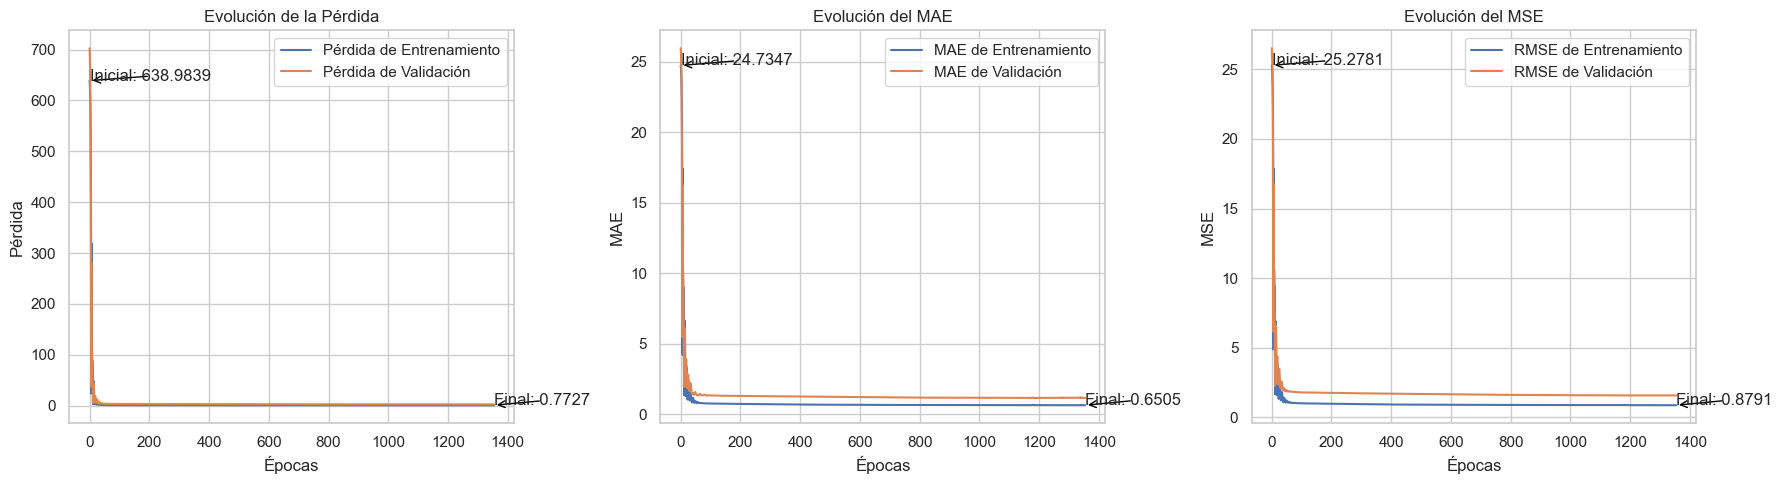

In [155]:
# Llamada a la función para graficar el historial
plot_training_history(history, epoch_start=0, epoch_end=None, tamaño=0.01)

La evolución del modelo en sus tres métricas es prometedora, ya que logró converger de manera estable sin presentar grandes fluctuaciones. Sin embargo, es necesario realizar un análisis más detallado en una pequeña vecindad alrededor del punto final, que incluya el valor mínimo, para comprender mejor el comportamiento del modelo en esa región específica.

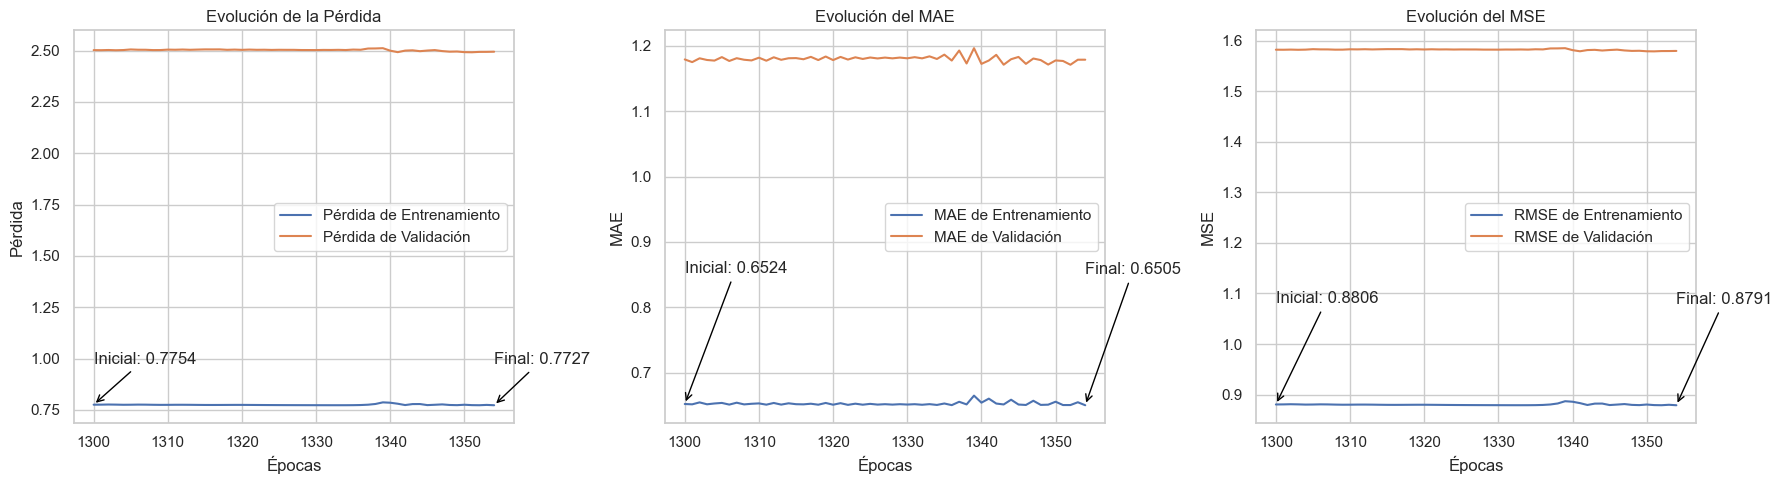

In [156]:
# Llamada a la función para graficar desde un intervalo "mas optimo"
plot_training_history(history, 
                      epoch_start=1300,
                      epoch_end= 1355, 
                      tamaño=0.2)

Desde el punto mínimo hasta el punto final, la diferencia es mínima, lo que indica que el modelo ha superado satisfactoriamente las pruebas hasta ahora. A continuación, se procederá a realizar un análisis más específico, enfocándose en el comportamiento del modelo con datos reales en lugar de solo en las métricas.

#### Evaluacion del modelo

##### Entrenamiento

Aunque los valores de entrenamiento son satisfactorios, es importante visualizar cómo se comportan estos datos y si proporcionan la aproximación necesaria. No debemos basarnos únicamente en las métricas, sino también en el comportamiento del modelo para obtener una comprensión más completa de su rendimiento.

In [157]:
# Establecer el modelo en modo de evaluación
model.eval()

# Realizar predicciones sin calcular gradientes sobre los datos de entrenamiento
with torch.no_grad():
    y_pred_train = model(X_train)

# Si es necesario, mover a la CPU y convertir a un array de NumPy
y_pred = y_pred_train.cpu().numpy() if y_pred_train.is_cuda else y_pred_train.numpy()

# Asegurarte de que y_train esté en formato NumPy también
y_train = y_train.cpu().numpy() if y_train.is_cuda else y_train.numpy()

# Ajustar y_train al tamaño de y_pred si es necesario
y_train = y_train[:y_pred.shape[0]]

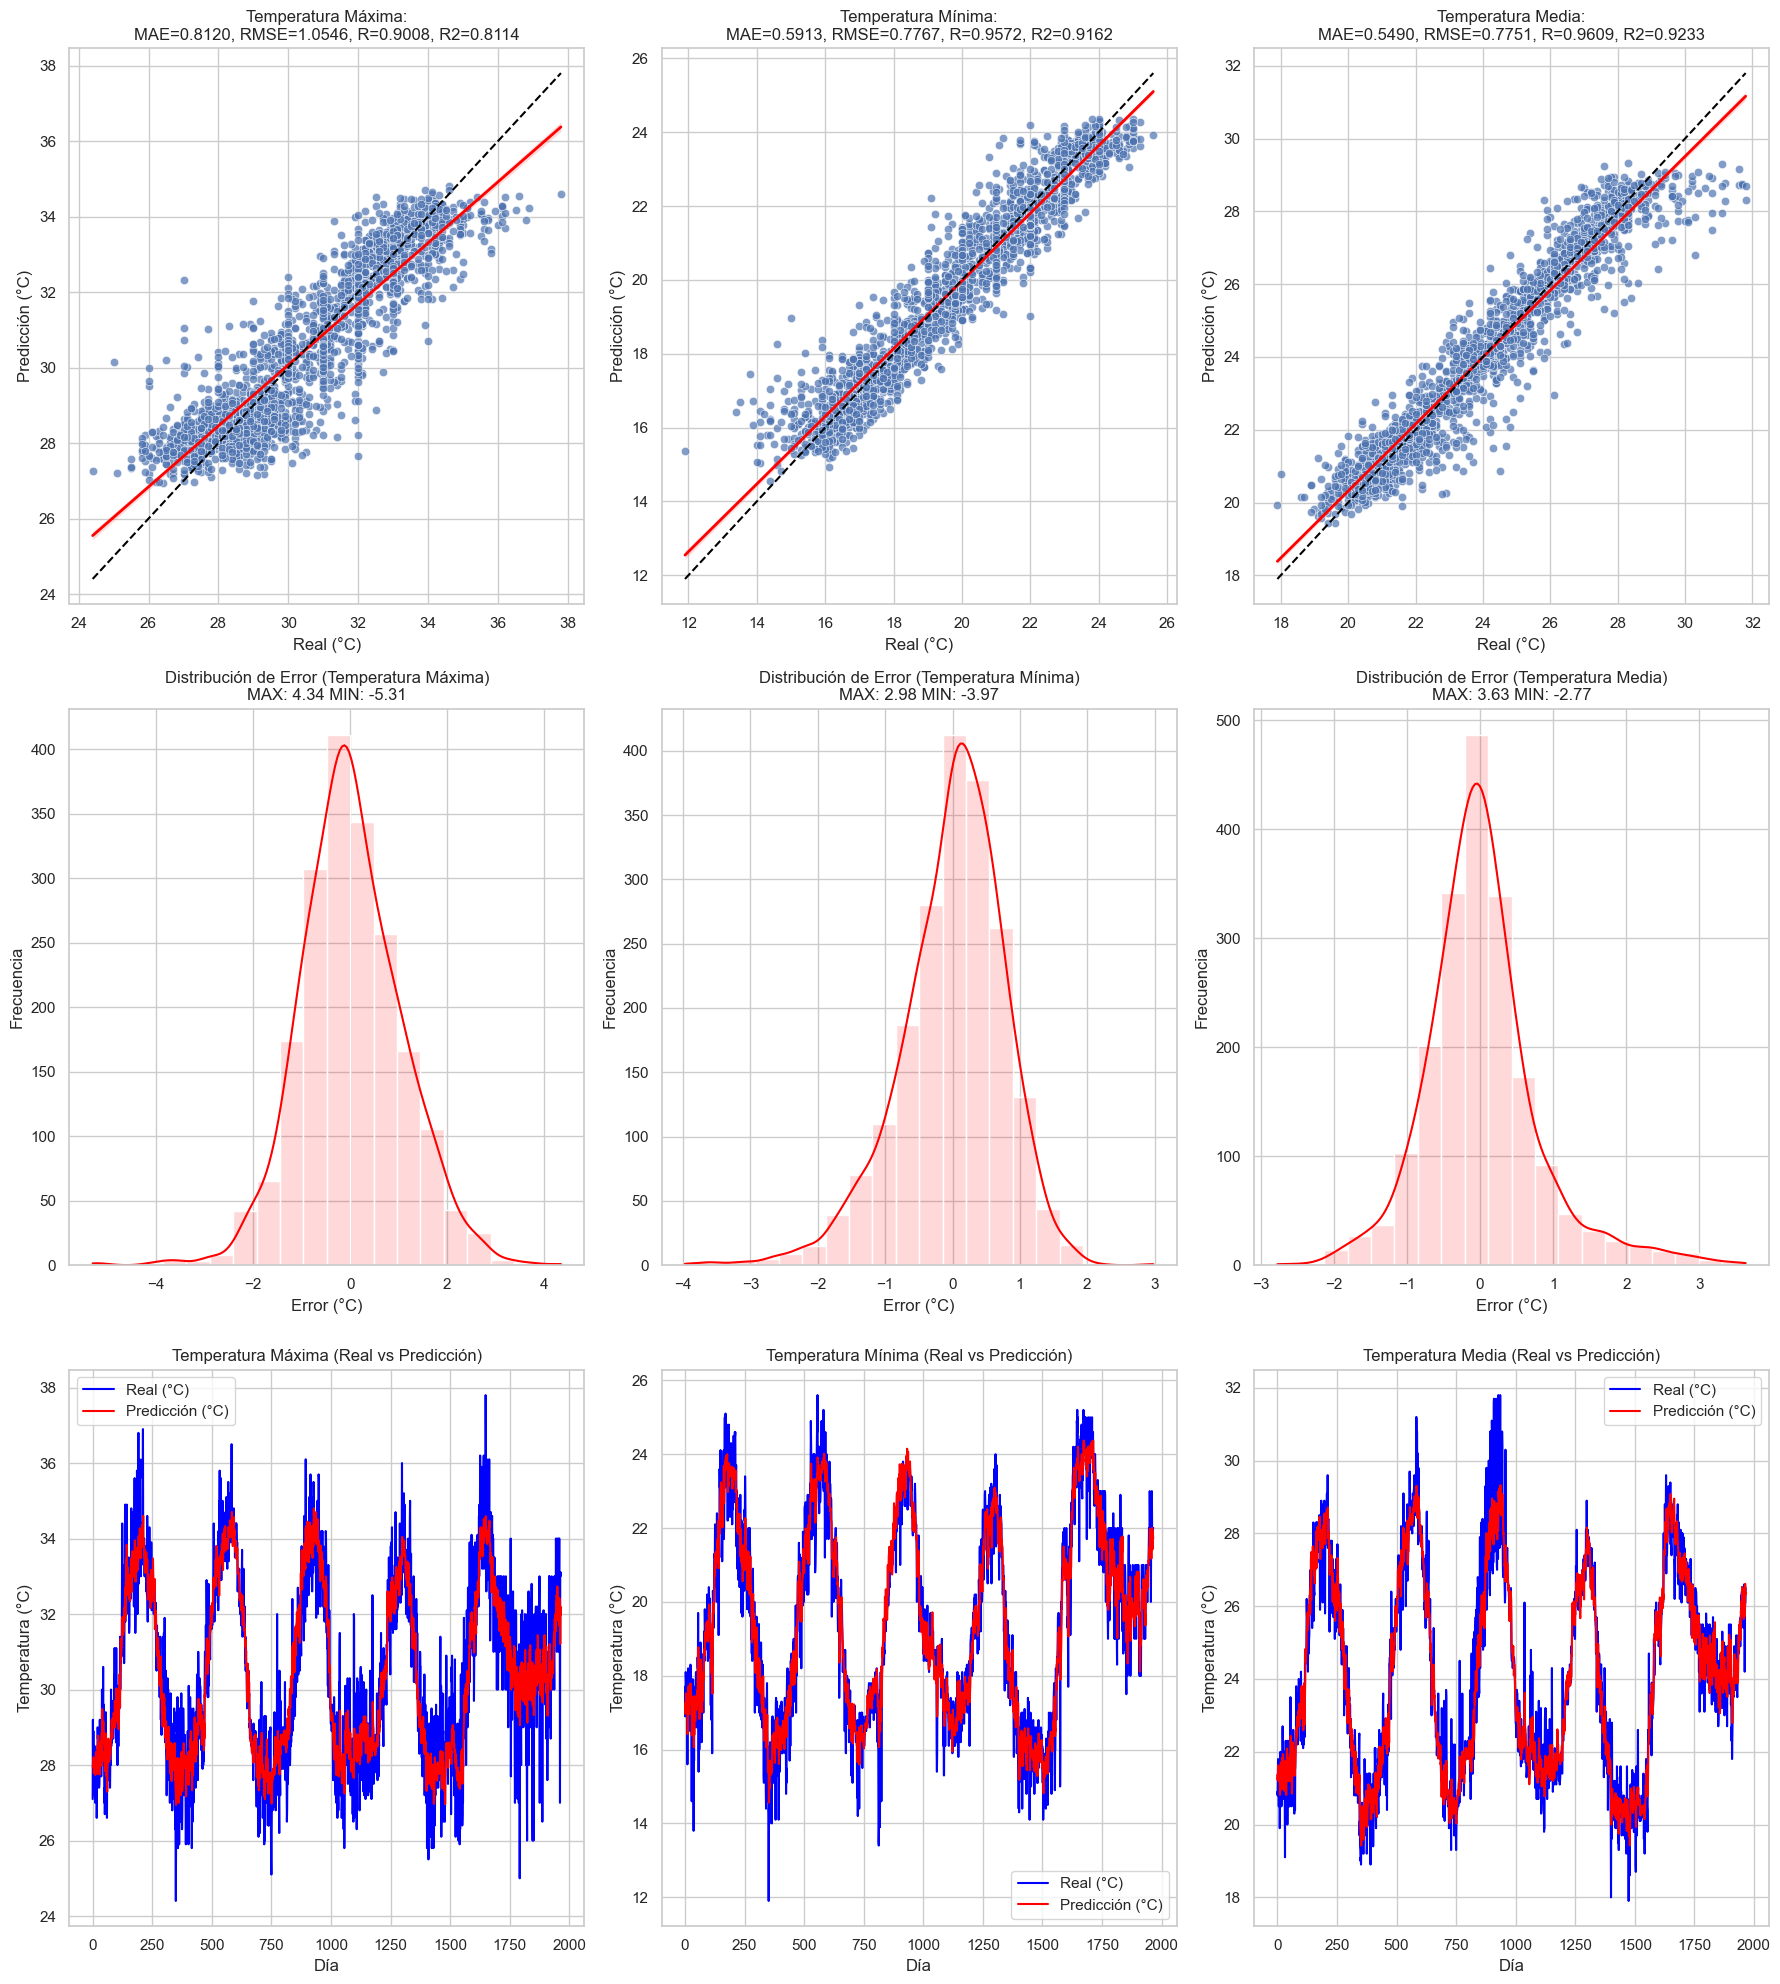

In [158]:
# Llamada a la función con los datos de entrenamiento y predicción
plot_temperature_errors(y_train, y_pred)

En el error medio absoluto, todos los valores son menores a 0.9, con una diferencia entre el valor real y el predicho inferior a 4.5. Además, el centro de la campana de Gauss está en 0, lo que indica un buen entrenamiento con los datos de entrenamiento. Ahora, falta analizar el comportamiento con los datos de validación, los cuales no fueron usados en el entrenamiento y representan nuevos escenarios para el modelo.

##### Validacion

In [159]:
# Establecer el modelo en modo de evaluación
model.eval()

# Realizar predicciones sin calcular gradientes
with torch.no_grad():
    y_pred_train = model(X_test)

# Si es necesario, mover a la CPU y convertir a un array de NumPy
y_pred = y_pred_train.cpu().numpy() if y_pred_train.is_cuda else y_pred_train.numpy()

# Asegurarte de que y_val esté en formato NumPy también
y_val = y_test.cpu().numpy() if y_test.is_cuda else y_test.numpy()

# Ajustar y_val al tamaño de y_pred si es necesario
y_val = y_val[:y_pred.shape[0]]

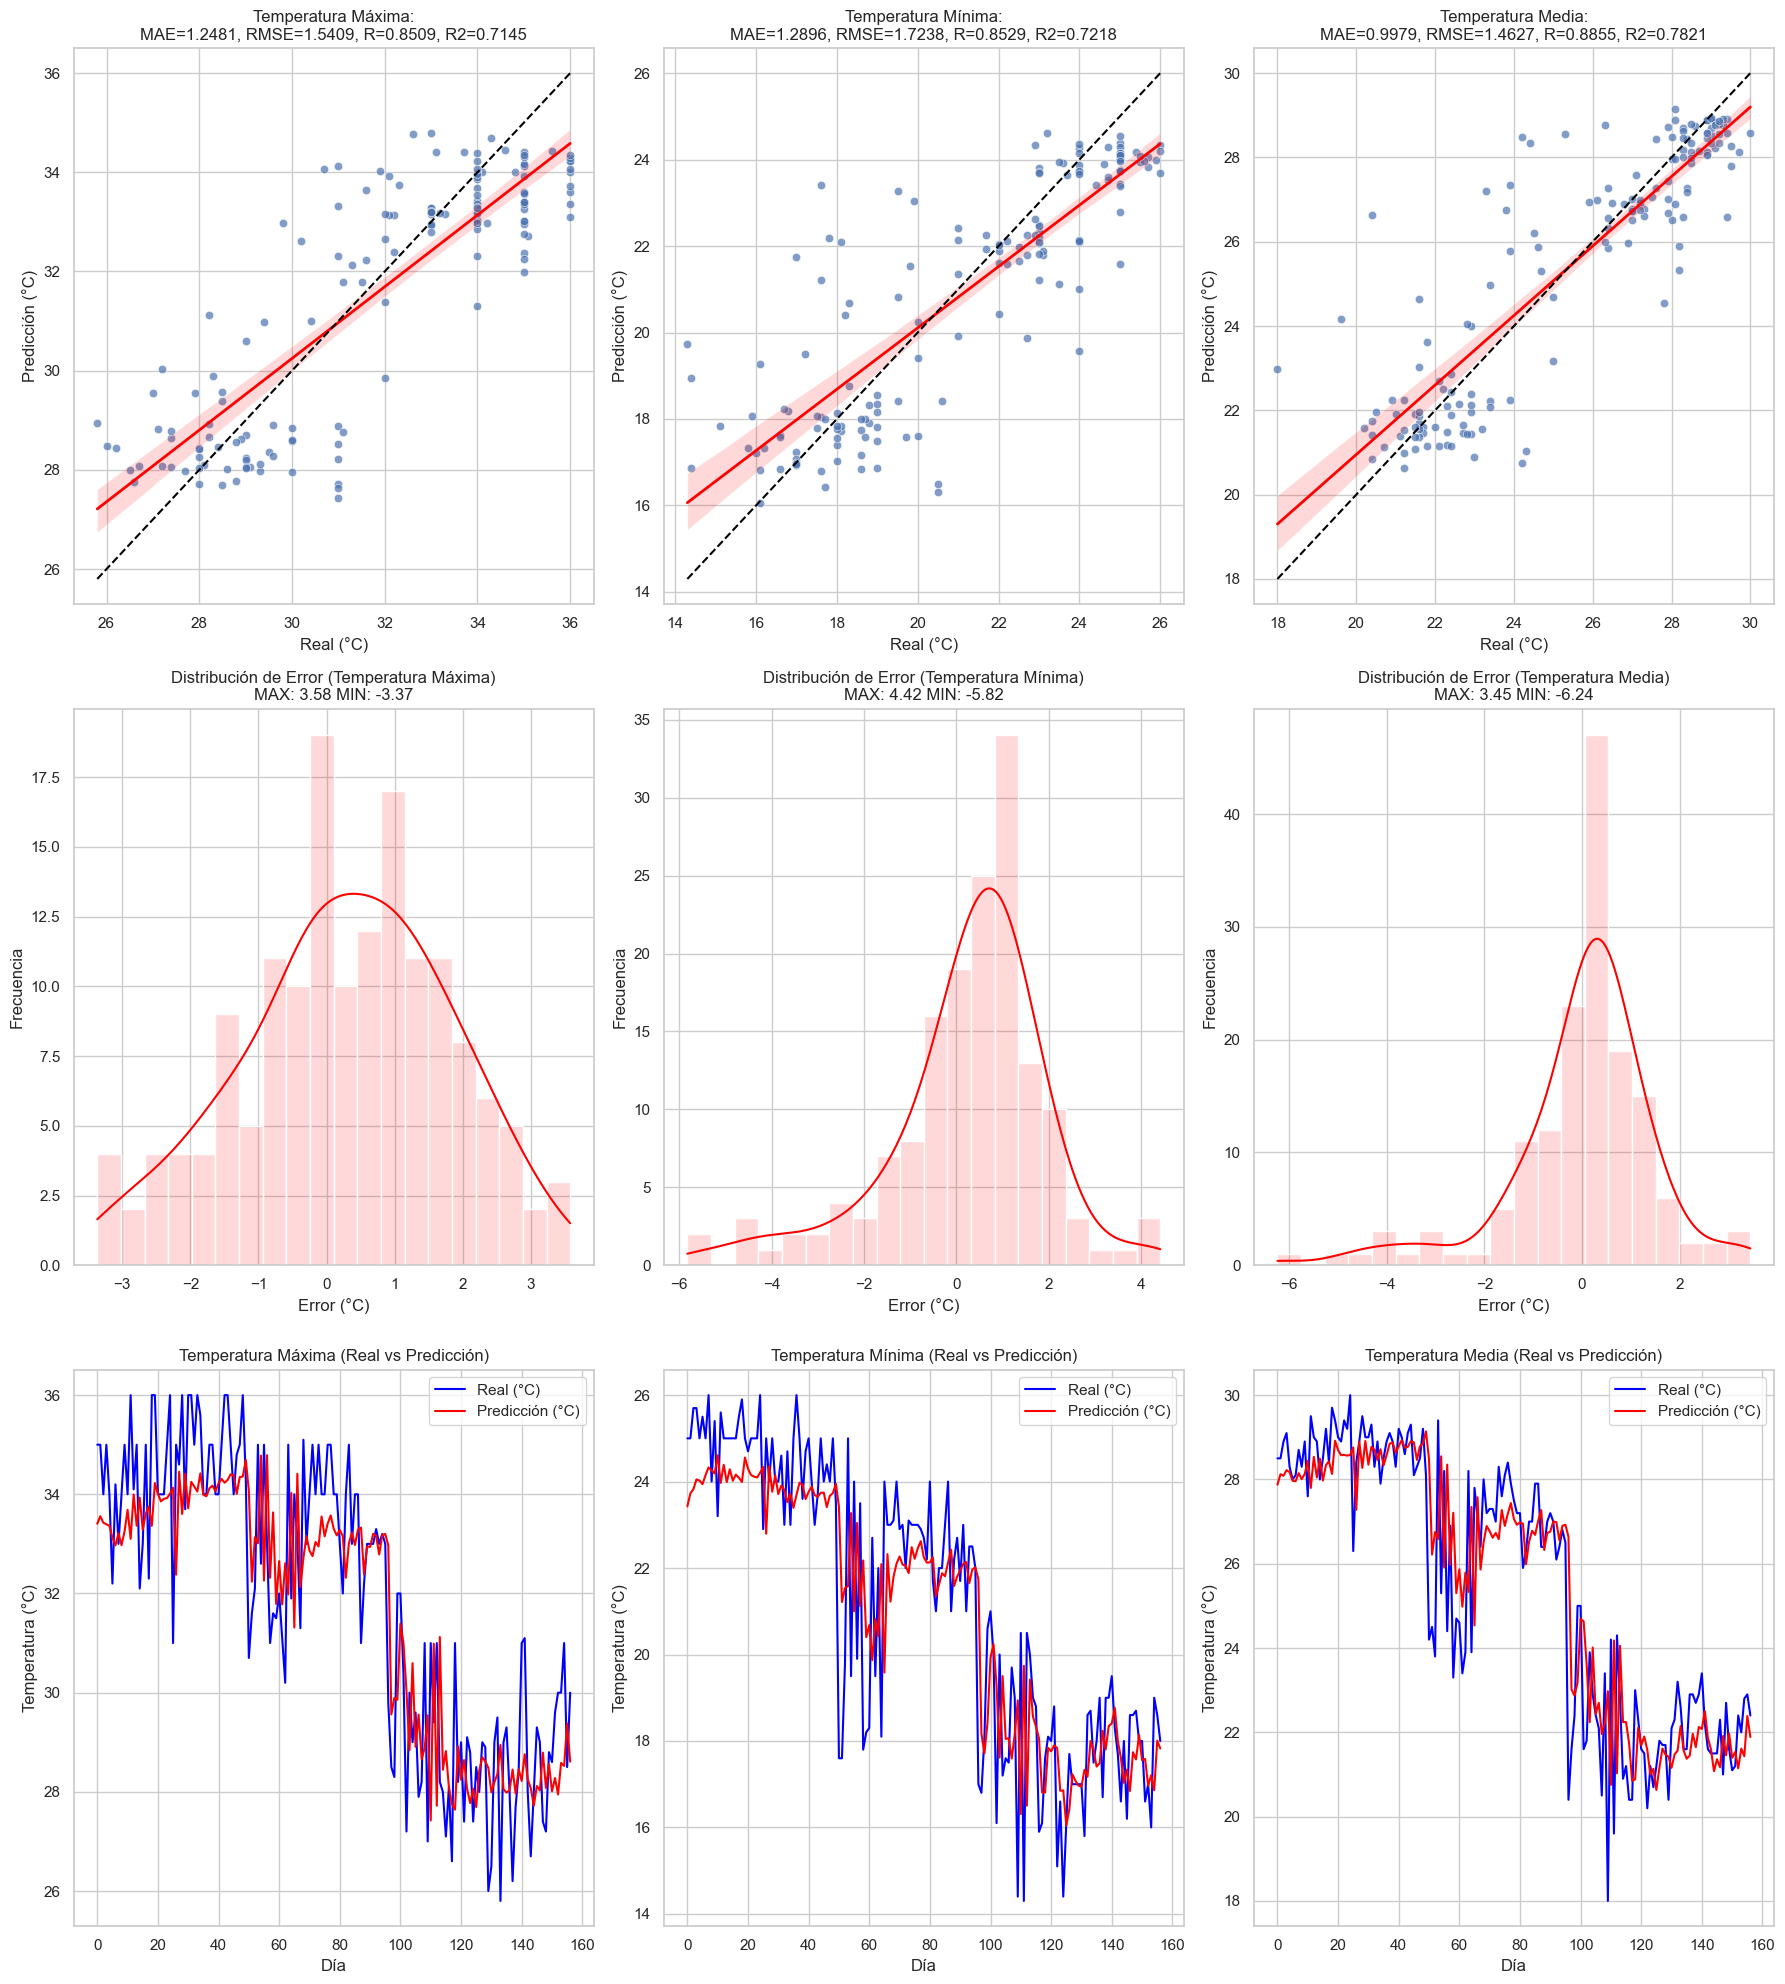

In [160]:
# Llamada a la función con los datos de entrenamiento y predicción
plot_temperature_errors(y_val, y_pred)

El error medio absoluto es inferior a 1.3 para todas las variables (excepto la media, que es predicha con mayor precisión). Observamos que el modelo identifica patrones de estacionalidad. Sin embargo, en las temperaturas máxima y mínima, al ser más caóticas, resulta más difícil lograr predicciones completamente precisas. A pesar de esto, el modelo sigue la tendencia de estas variables y mantiene márgenes de error aceptables, incluso en ciertos picos asociados a cambios estacionales.

Aunque la campana de Gauss tiene su centro desplazado ligeramente hacia la derecha, lo que indica que no alcanza un error cero, se aproxima considerablemente. Considerando la variabilidad del modelo, los patrones estacionales y el comportamiento más caótico de ciertas variables, el modelo validado presenta un error mayor al de entrenamiento, como es de esperarse. Sin embargo, se concluye que este modelo es aceptable, ya que reproduce patrones muy similares a los reales cuando se enfrenta a datos no vistos, lo cual lo hace adecuado para realizar predicciones futuras.

##### Verificar la importancia de las variables

Este paso tiene como objetivo verificar si las variables eliminadas tienen una contribución insignificante para el modelo. Esto se realiza para identificar y descartar características que no aporten valor predictivo significativo, optimizando así la eficiencia y rendimiento del modelo.

Se lleva a cabo después de evaluar los errores de entrenamiento y validación, lo que nos permite asegurarnos de que el modelo esté ajustado adecuadamente antes de proceder con esta etapa. Esto es útil para reducir la complejidad del modelo, evitar el sobreajuste y facilitar su interpretación, manteniendo únicamente las variables relevantes para las predicciones.

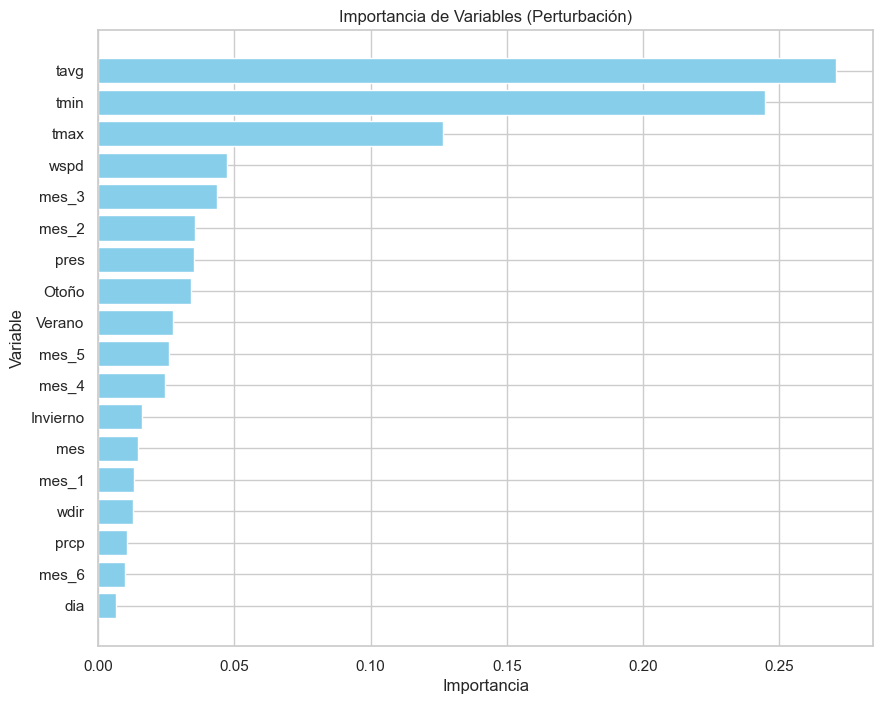

In [161]:
model.eval()
X_test_tensor = X_test.to(device).float() 

# Predicción original
with torch.no_grad():
    pred_original = model(X_test_tensor).cpu().numpy()

# Calcular la importancia de cada variable
importancia = []
for i in range(X_test_tensor.shape[2]):
    X_perturbado = X_test_tensor.clone() 
    indices = torch.randperm(X_test_tensor.shape[0])  
    X_perturbado[:, :, i] = X_perturbado[indices, :, i] 
    
    # Predecir con los datos perturbados
    with torch.no_grad():
        pred_perturbado = model(X_perturbado).cpu().numpy()
    
    # Calcular la diferencia promedio de las predicciones
    delta = np.mean(np.abs(pred_original - pred_perturbado))
    importancia.append(delta)

# Normalizar las importancias
importancia = np.array(importancia) / np.sum(importancia)

# Crear un DataFrame para visualizar los resultados
importancia_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importancia
}).sort_values(by='Importancia', ascending=False)

# Visualizar las importancias en un gráfico
plt.figure(figsize=(10, 8))
plt.barh(importancia_df['Variable'], importancia_df['Importancia'], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de Variables (Perturbación)')
plt.gca().invert_yaxis()  # Invertir el eje para que las más importantes estén arriba
plt.show()

Aquí se observa que las variables relacionadas con la temperatura tienen una alta importancia para el modelo, al igual que ciertas estaciones y meses específicos. Esta gráfica corresponde al modelo ya afinado, lo que significa que las variables menos relevantes ya han sido eliminadas en etapas previas.

Si se desea realizar una nueva corroboración, será necesario regresar al apartado de características y ajustar el vector de entrada eliminando aquellas variables que previamente se identificaron como de baja relevancia. Esto asegura que cualquier análisis adicional se realice con una base optimizada y consistente.

#### Guardar Modelo

Finalmente, se guarda el modelo entrenado para su uso posterior en un programa automatizado, permitiendo realizar predicciones de manera eficiente con nuevos datos.

In [162]:
# Construir la ruta completa para guardar el modelo
model_path = os.path.join(current_directory, 'modelo_completo.pth')

# Guardar el modelo completo (incluyendo la arquitectura y los pesos)
torch.save(model, model_path)

print("Modelo guardado exitosamente en", model_path)

Modelo guardado exitosamente en C:\Users\Ronaldo Olivares\Desktop\DOCUMENTO DE TESIS\Codigos\modelo_completo.pth
